## Validation process

    #results for -30ft, -20ft, and -10ft

In [10]:
#General libraries DEM Bathymetry
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#General libraries HEC-RAS
import h5py
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import matplotlib.dates as mdates

#Error metrics libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error



## Cross Sections locations

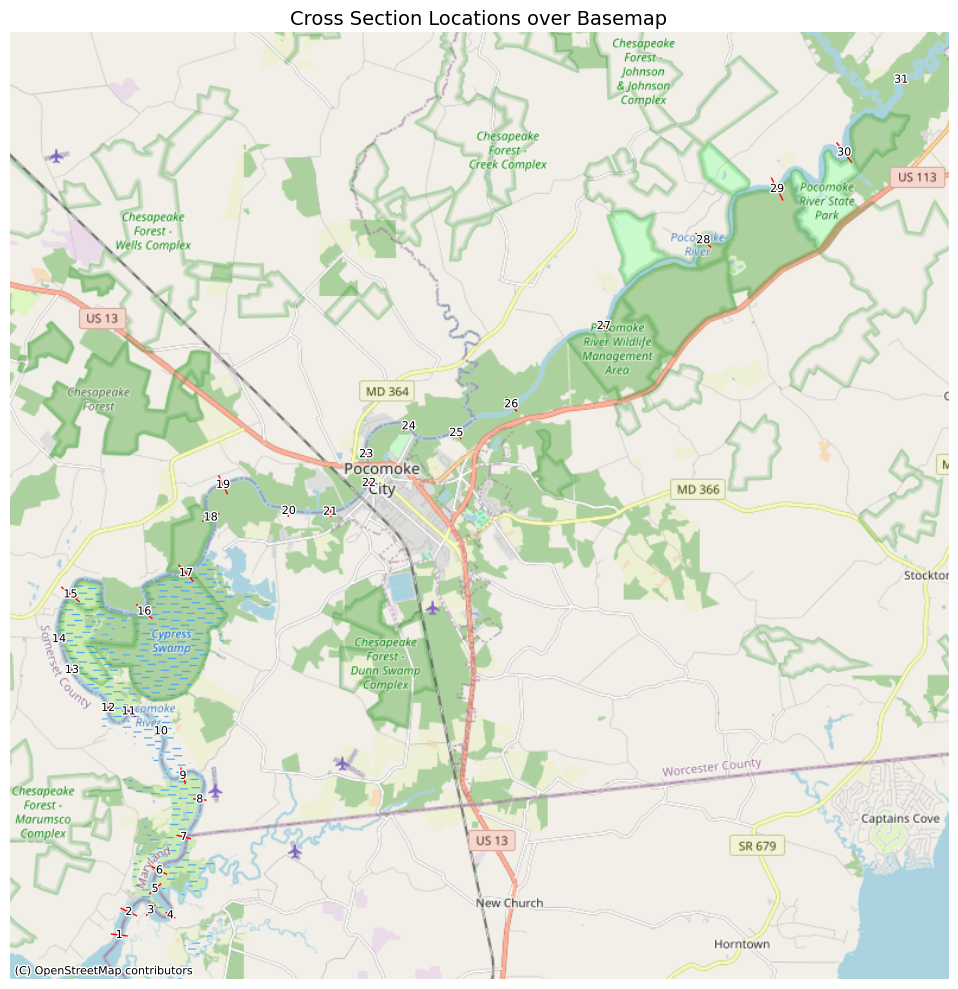

In [140]:
#Load your shapefile
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

#Convert to Web Mercator (required for basemap tiles)
lines_gdf = lines_gdf.to_crs(epsg=3857)

#Plot
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


##  Coastal validation

# Boundary Condition data
(Sheltown gage)


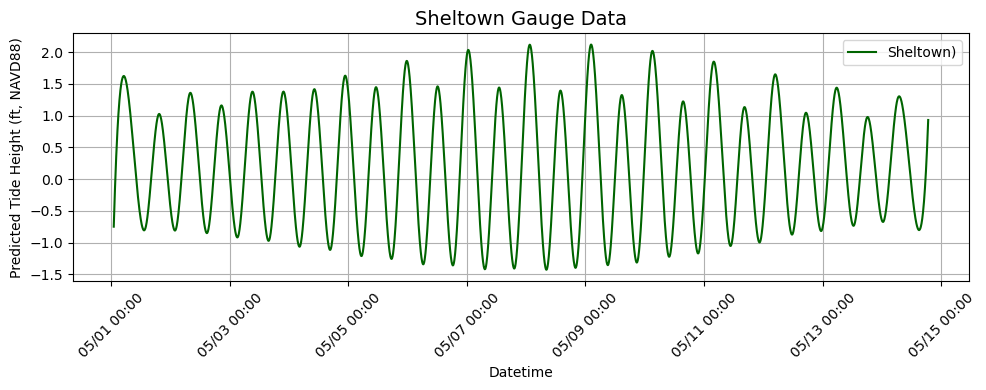

In [ ]:
#Gauge plot -#Sheltown gauge data - BC

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\tides_6min_spline.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet1")

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Datetime",
    df.columns[1]: "Water Level (ft)",
}, inplace=True)

# === Plot with full datetime labels
plt.figure(figsize=(10, 4))
plt.plot(df["Datetime"], df["Water Level (ft)"], label="Sheltown)", color='darkgreen')
plt.title("Sheltown Gauge Data", fontsize=14)
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()

# Carv 13 + channel 2
    -30ft channel + new polygon


##Results for 31 cross sections  

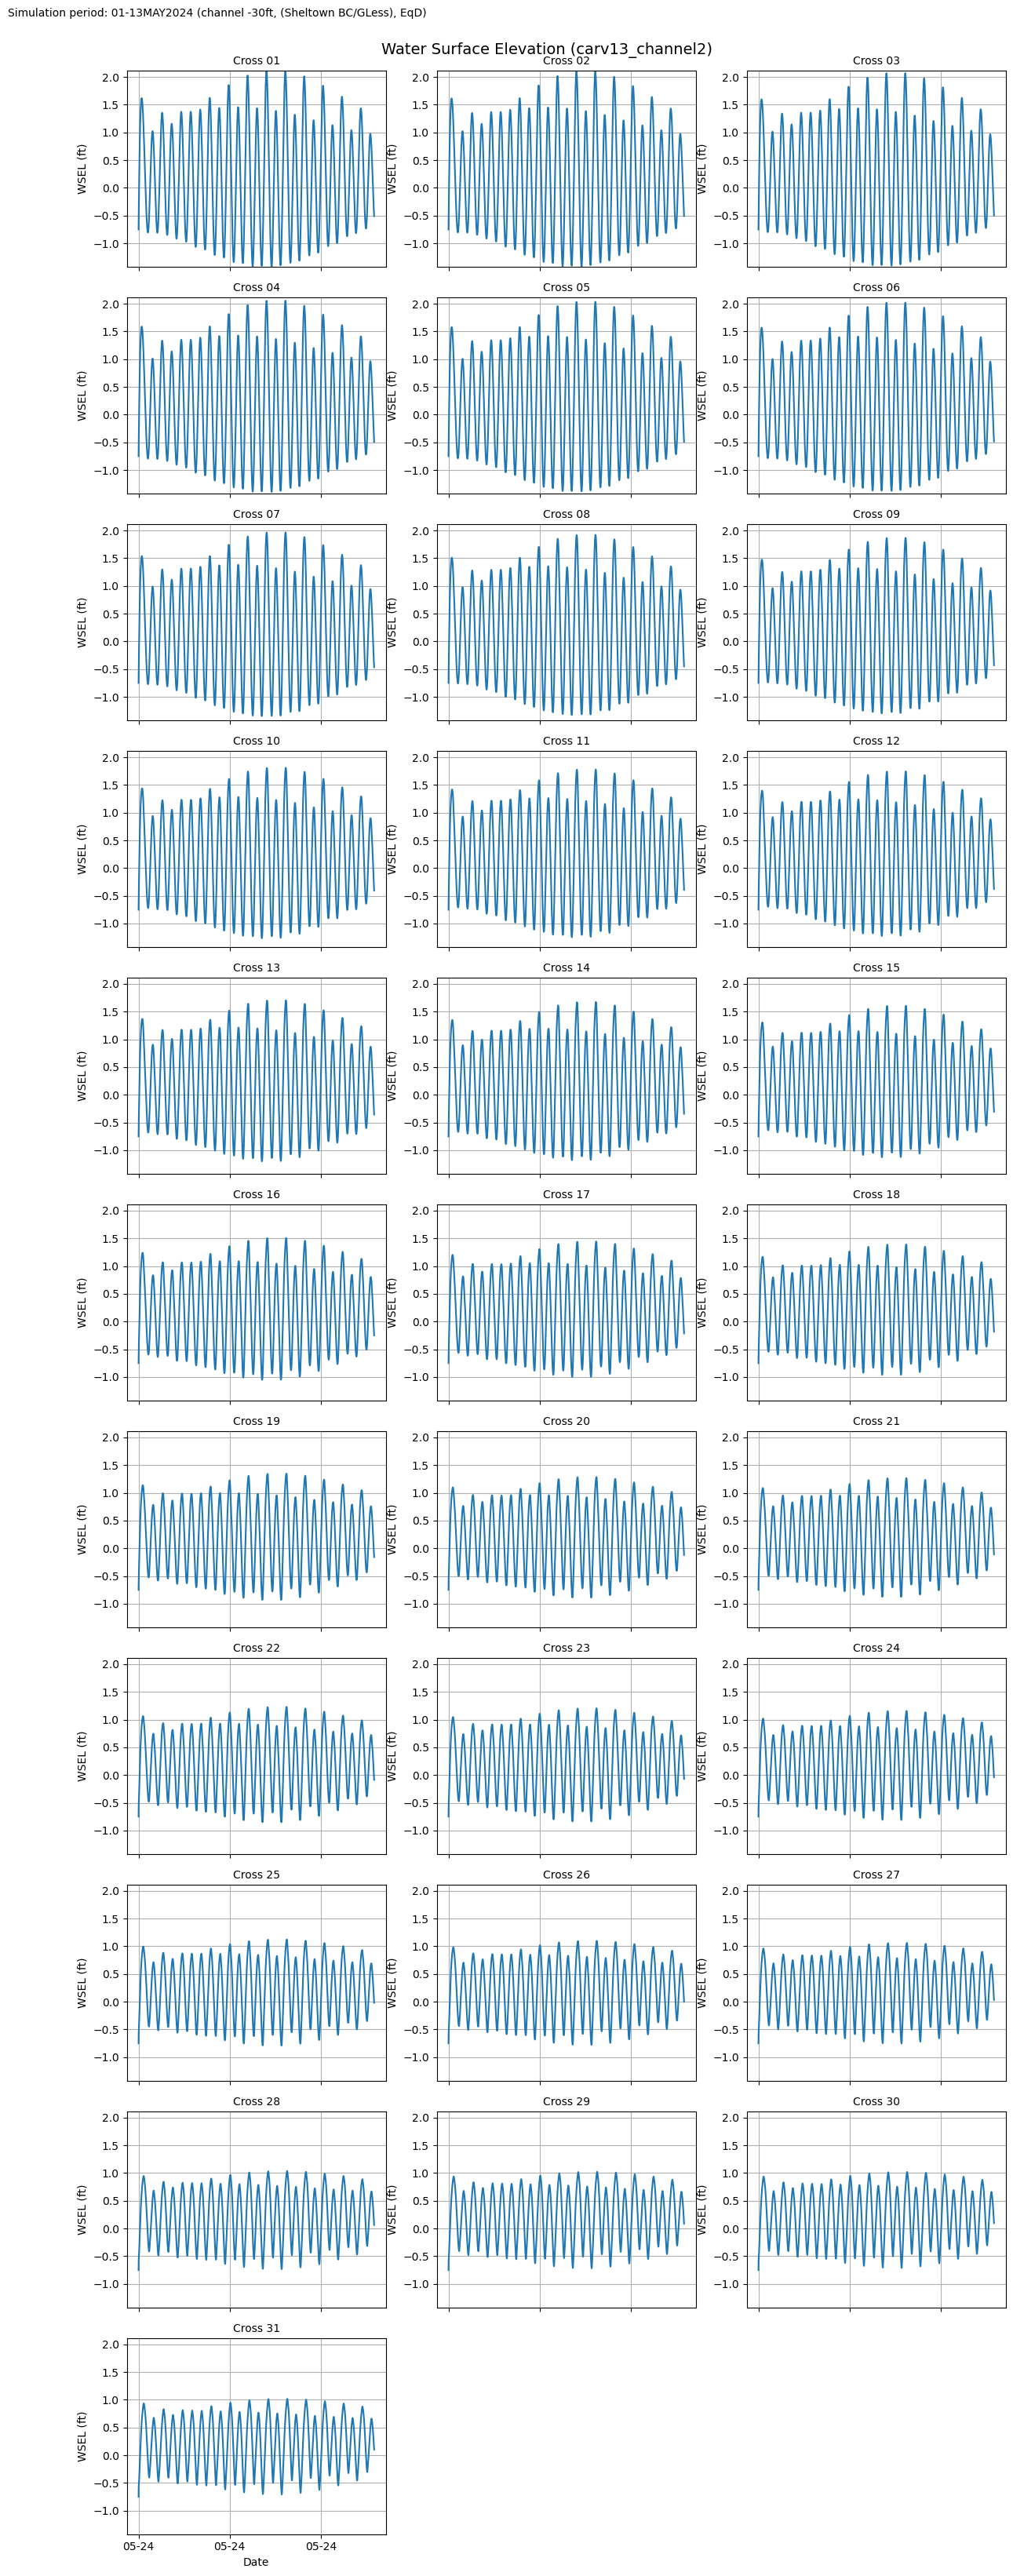

Saved: 13wsel_cellsGless.csv


In [3]:
## Tides Simulation (WSEL)  at 31 Cross Sections Plan: 'int2_Shel_2024_NAVD88_carv13cjan2' (v5.p94)
# === FILES INPUTS ===
hdf_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\hec641\v5.p94.hdf" #Gless
cell_ids = [628120, 627951, 627921, 628029, 627746, 627684, 627618, 627572, 627530, 627472, 627396, 627381,
            635980, 635128, 636050, 635000, 634940, 627311, 634847, 636360, 694557, 845840, 827923, 814408,
            660900, 647501, 634688, 634563, 636676, 627066, 634263]

# === OPEN HDF FILE ===
with h5py.File(hdf_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations (not used here but useful to keep)
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build WSEL dataframe
    wsel_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        wsel_data[f'Cell_{cid}'] = ws

# === CREATE FINAL DATAFRAME ===
wsel_df = pd.DataFrame(wsel_data, index=pd.to_datetime(time_index))
wsel_df.index.name = 'Datetime'

# === Mapping Cell ID → Cross Section Name ===
cell_to_cross = {
    628120: "Cross 01", 627951: "Cross 02", 627921: "Cross 03", 628029: "Cross 04", 627746: "Cross 05",
    627684: "Cross 06", 627618: "Cross 07", 627572: "Cross 08", 627530: "Cross 09", 627472: "Cross 10",
    627396: "Cross 11", 627381: "Cross 12", 635980: "Cross 13", 635128: "Cross 14", 636050: "Cross 15",
    635000: "Cross 16", 634940: "Cross 17", 627311: "Cross 18", 634847: "Cross 19", 636360: "Cross 20",
    694557: "Cross 21", 845840: "Cross 22", 827923: "Cross 23", 814408: "Cross 24", 660900: "Cross 25",
    647501: "Cross 26", 634688: "Cross 27", 634563: "Cross 28", 636676: "Cross 29", 627066: "Cross 30",
    634263: "Cross 31"
}

# === GLOBAL Y-AXIS RANGE ===
global_min = wsel_df.min().min()
global_max = wsel_df.max().max()

# === Prepare Grid ===
num_cells = len(wsel_df.columns)
cols = 3
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

# === Plot with Fixed Y-axis ===
for i, col in enumerate(wsel_df.columns):
    cell_id = int(col.replace("Cell_", ""))
    cross_name = cell_to_cross.get(cell_id, col)

    ax = axes[i]
    ax.plot(wsel_df.index, wsel_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("WSEL (ft)")
    ax.set_ylim(global_min, global_max)
    ax.grid(True)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Date")

# === Remove Unused Subplots ===
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# === Figure Title and Layout ===
fig.suptitle("Water Surface Elevation (carv13_channel2)", fontsize=14)
fig.text(0.15, 0.99, "Simulation period: 01-13MAY2024 (channel -30ft, (Sheltown BC/GLess), EqD)", ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

#Save to CSV ===
wsel_df.to_csv('13wsel_cellsGLess.csv')
print("Saved: 13wsel_cellsGless.csv")

#Compare model results and Shelltown gauge: Reference:  cross 2

#Compare model results and Snow Hill gauge: Reference cross 31

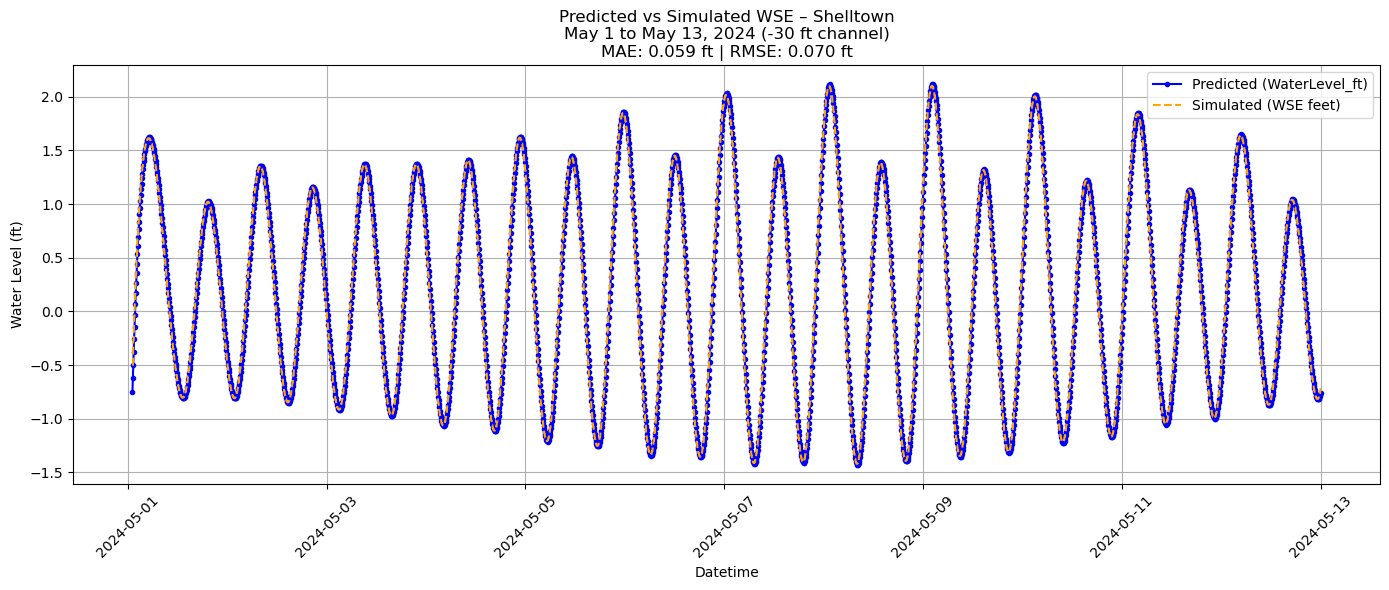

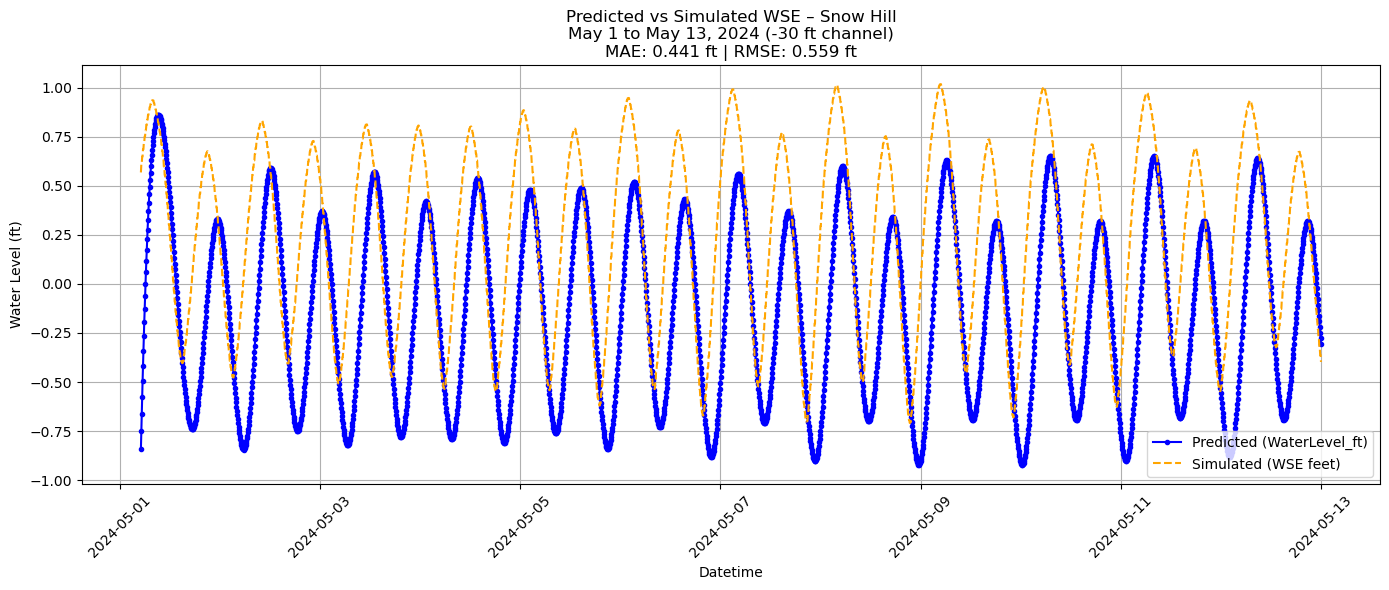

In [ ]:

# === File paths: observed and simulated data for each location ===
file_obs_shel = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\tides_6min_spline_Shel.xlsx"
file_sim_shel = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\hec641\gage_closeShel_GL13_channel2.xlsx"

file_obs_snow = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\tides_6min_spline_snow.xlsx"
file_sim_snow = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\hec641\closesnow_GL13_channel2.xlsx"

# === Function to load, align, compare, and plot observed vs simulated WSE ===
def compare_and_plot(file_obs, file_sim, location_name, channel_depth):
    # Load Excel files
    df_obs = pd.read_excel(file_obs)
    df_sim = pd.read_excel(file_sim)

    # Remove any extra spaces in column names
    df_obs.columns = df_obs.columns.str.strip()
    df_sim.columns = df_sim.columns.str.strip()

    # Convert string columns to datetime format
    df_obs['Datetime'] = pd.to_datetime(df_obs['DateTime'])
    df_sim['Datetime'] = pd.to_datetime(df_sim['DateTime'])

    # Define common validation period
    start_date = pd.to_datetime("2024-05-01")
    end_date = pd.to_datetime("2024-05-13")

    # Filter both datasets for the desired date range
    df_obs_filtered = df_obs[(df_obs['Datetime'] >= start_date) & (df_obs['Datetime'] <= end_date)]
    df_sim_filtered = df_sim[(df_sim['Datetime'] >= start_date) & (df_sim['Datetime'] <= end_date)]

    # Interpolate simulated values so they can be aligned with observed timestamps
    sim_interp = df_sim_filtered.set_index('Datetime')['WSE (feet)'].interpolate(method='time')

    # Align simulated values to observed timestamps (nearest within 5 minutes)
    sim_on_obs = sim_interp.reindex(df_obs_filtered['Datetime'], method='nearest', tolerance=pd.Timedelta('5min'))

    # Combine observed and simulated values into a single DataFrame
    df_plot = pd.DataFrame({
        'Datetime': df_obs_filtered['Datetime'],
        'Observed': df_obs_filtered['WaterLevel_ft'].values,
        'Simulated': sim_on_obs.values
    }).dropna()  # Drop rows with any missing values

    # Calculate error metrics: MAE and RMSE
    mae = mean_absolute_error(df_plot['Observed'], df_plot['Simulated'])
    rmse = np.sqrt(mean_squared_error(df_plot['Observed'], df_plot['Simulated']))

    # === Plot the results ===
    plt.figure(figsize=(14, 6))
    plt.plot(df_plot['Datetime'], df_plot['Observed'],
             label='Predicted (WaterLevel_ft)', color='blue', linestyle='-', marker='o', markersize=3)
    plt.plot(df_plot['Datetime'], df_plot['Simulated'],
             label='Simulated (WSE feet)', color='orange', linestyle='--', linewidth=1.5)

    # Title includes location, channel depth, and error metrics
    plt.title(f'Predicted vs Simulated WSE – {location_name}\nMay 1 to May 13, 2024 ({channel_depth} ft channel)\n'
              f'MAE: {mae:.3f} ft | RMSE: {rmse:.3f} ft')

    # Axis labels and formatting
    plt.xlabel('Datetime')
    plt.ylabel('Water Level (ft)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Run the function for both Shelltown and Snow Hill ===
compare_and_plot(file_obs_shel, file_sim_shel, "Shelltown", -30)
compare_and_plot(file_obs_snow, file_sim_snow, "Snow Hill", -30)


## Precipitation validation